# Причиность

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !wget -q -O requirements.txt https://raw.githubusercontent.com/Intelligent-Systems-Phystech/psad/master/seminars/sem11/requirements.txt
    !pip install -qU -r requirements.txt
    !pip install -qU matplotlib==2.2.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 2.2.3 which is incompatible.
bigframes 1.4.0 requires matplotlib>=3.7.1, but you have matplotlib 2.2.3 which is incompatible.
datascience 0.17.6 requires matplotlib>=3.0.0, but you have matplotlib 2.2.3 which is incompatible.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 2.2.3 which is incompatible.
mlxtend 0.22.0 requires matplotl

## Библиотеки

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import pandas as pd
import seaborn as sns

from causality.estimation.adjustments import AdjustForDirectCauses
from causality.estimation.nonparametric import CausalEffect
from causality.inference.search import IC
from causality.inference.independence_tests import MutualInformationTest
from causalgraphicalmodels import CausalGraphicalModel

import dowhy
from dowhy import CausalModel

## Warmup

### Связь в линейной регрессии

#### Fork

Смоделируем зависимости,соответствующие типу Fork.

Заметим, что здесь есть только одна переменная, которая является экзогенной (Z), то есть она не зависит ни от какой другой переменной в системе (не зависит от X, Y, эндогенных переменных).

$$Z->X, Z->Y, X->Y$$

![title](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/seminars/sem11/data/fork.png?raw=1)

In [7]:
rs = np.random.RandomState(42)
N = 10000
Z = rs.randn(10000)
X = 0.5 * Z + rs.randn(10000)
Y = 0.3 * Z + 0.4 * X + rs.randn(10000)

Построим разные регрессии регрессии Y ~ X, Y ~ Z + X, Y ~ Z. Что можно сказать о 95% доверительном интервале (confint) на коэффициент регрессии перед X в двух этих моделях?

In [8]:
l1 = OLS(Y, np.vstack([X]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.263
Model:                            OLS   Adj. R-squared (uncentered):              0.263
Method:                 Least Squares   F-statistic:                              3564.
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        15:44:53   Log-Likelihood:                         -14486.
No. Observations:               10000   AIC:                                  2.897e+04
Df Residuals:                    9999   BIC:                                  2.898e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5511      0.009     59.699      0.000       0.533       0.569
==============================================================================
Omnibus:                        0.062   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.969   Jarque-Bera (JB):                0.051
Skew:                          -0.004   Prob(JB):                        0.975
Kurtosis:                       3.007   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
l1 = OLS(Y, np.vstack([X, Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):              0.318
Method:                 Least Squares   F-statistic:                              2331.
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        15:44:53   Log-Likelihood:                         -14096.
No. Observations:               10000   AIC:                                  2.820e+04
Df Residuals:                    9998   BIC:                                  2.821e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4266      0.010     43.099      0.000       0.407       0.446
x2             0.3134      0.011     28.467      0.000       0.292       0.335
==============================================================================
Omnibus:                        3.320   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.190   Jarque-Bera (JB):                3.163
Skew:                           0.007   Prob(JB):                        0.206
Kurtosis:                       2.914   Cond. No.                         1.63
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
l1 = OLS(Y, np.vstack([Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.191
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                              2366.
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        15:44:53   Log-Likelihood:                         -14948.
No. Observations:               10000   AIC:                                  2.990e+04
Df Residuals:                    9999   BIC:                                  2.991e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5230      0.011     48.641      0.000       0.502       0.544
==============================================================================
Omnibus:                       12.818   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.305
Skew:                           0.029   Prob(JB):                      0.00351
Kurtosis:                       2.846   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Collider

Рассмотрим collider:
```
X -> Z
X -> Y
Y -> Z
```

![title](https://github.com/Intelligent-Systems-Phystech/psad/blob/master/seminars/sem11/data/collider.png?raw=1)

In [11]:
X = rs.randn(N)
Y = 0.7 * X + rs.randn(N)
Z = 1.2 * X + 0.6 * Y + rs.randn(N)

In [12]:
l1 = OLS(Y, np.vstack([X]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.336
Model:                            OLS   Adj. R-squared (uncentered):              0.336
Method:                 Least Squares   F-statistic:                              5053.
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        15:44:55   Log-Likelihood:                         -14193.
No. Observations:               10000   AIC:                                  2.839e+04
Df Residuals:                    9999   BIC:                                  2.839e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7079      0.010     71.083      0.000       0.688       0.727
==============================================================================
Omnibus:                        3.522   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                3.548
Skew:                          -0.045   Prob(JB):                        0.170
Kurtosis:                       2.978   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
l1 = OLS(Y, np.vstack([X, Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                              5084.
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        15:44:55   Log-Likelihood:                         -12730.
No. Observations:               10000   AIC:                                  2.546e+04
Df Residuals:                    9998   BIC:                                  2.548e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0107      0.015      0.725      0.468      -0.018       0.040
x2             0.4311      0.007     58.298      0.000       0.417       0.446
==============================================================================
Omnibus:                        0.285   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.867   Jarque-Bera (JB):                0.269
Skew:                          -0.012   Prob(JB):                        0.874
Kurtosis:                       3.010   Cond. No.                         4.02
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
l1 = OLS(Y, np.vstack([Z]).T).fit()
l1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                          1.017e+04
Date:                Fri, 03 May 2024   Prob (F-statistic):                        0.00
Time:                        15:44:55   Log-Likelihood:                         -12730.
No. Observations:               10000   AIC:                                  2.546e+04
Df Residuals:                    9999   BIC:                                  2.547e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4355      0.004    100.838      0.000       0.427       0.444
==============================================================================
Omnibus:                        0.272   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.873   Jarque-Bera (JB):                0.256
Skew:                          -0.011   Prob(JB):                        0.880
Kurtosis:                       3.010   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### DAGs (Directed Acyclic Graphs)

#### Рассмотрим простой граф

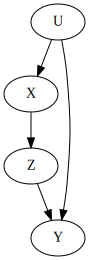

In [15]:
G = CausalGraphicalModel(nodes=['U', 'Z', 'X', 'Y'], edges=[
    ('U', 'Y'),
    ('U', 'X'),
    ('X', 'Z'),
    ('Z', 'Y')
])
G.draw()

#### Найдем все пути в графе (без циклов)

In [16]:
list(nx.all_simple_paths(G.dag, 'X', 'Y'))

[['X', 'Z', 'Y']]

#### Все пути, если считать граф не ориентированным

In [17]:
list(nx.all_simple_paths(G.dag.to_undirected(), 'X', 'Y'))

[['X', 'U', 'Y'], ['X', 'Z', 'Y']]

#### Рассмотрим все зависимости

In [18]:
G.get_all_independence_relationships()

[('Z', 'U', {'X'}), ('X', 'Y', {'U', 'Z'})]

#### Сгенерим распределение

In [19]:
G.get_distribution()

'P(U)P(X|U)P(Z|X)P(Y|U,Z)'

#### Обусловимся на переменную X

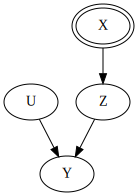

In [20]:
G.do('X').draw()

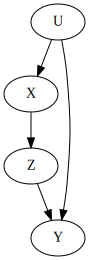

In [21]:
G.draw()

In [22]:
G.get_all_backdoor_adjustment_sets('Y','X')

frozenset({frozenset({'U', 'Z'})})

In [23]:
G.get_all_frontdoor_adjustment_sets('Y','X')

frozenset({frozenset()})

In [24]:
G.get_all_frontdoor_adjustment_sets('X','Y')

frozenset({frozenset({'Z'})})

## Inductive search

Допустим, у нас есть несколько событий:

1. Продажа мороженного (ICE)
2. Количество преступлений (CRIMES)
3. Количество полицейских на тысячу человек (POLICE)
4. Средняя температура (TEMP)
5. Количество скачиваний браузера IE (IE)
6. Количество зараженных компьютеров (COMP)
7. Уровень загрязнения воздуха (AIR)

P.S. Полная синтетика!

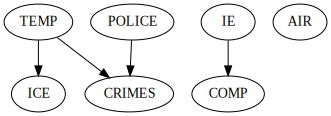

In [25]:
G = CausalGraphicalModel(nodes=['ICE','CRIMES','POLICE', 'TEMP','IE','COMP', 'AIR'],
edges=[('TEMP','ICE'),  ('TEMP','CRIMES'), ('IE','COMP'), ('POLICE', 'CRIMES')])
G.draw()

In [26]:
rs = np.random.RandomState(42)
police = rs.uniform(low=1, high=100, size=1000)
temp = rs.uniform(low=-40, high=40, size=1000)
air = rs.uniform(size=1000)
crimes = (temp + 40) / police
ice = temp + 40
ie = rs.uniform(size=1000)
comp = ie**2
dataframe = pd.DataFrame({'police':police, 'temp':temp, 'air':air, 'crimes':crimes, 'ice':ice, 'ie':ie, 'comp':comp})

In [27]:
dataframe

,police,temp,air,crimes,ice,ie,comp
0,38.079472,-25.189366,0.261706,0.388940,14.810634,0.672703,0.452529
1,95.120716,3.352076,0.246979,0.455759,43.352076,0.796681,0.634701
2,73.467400,29.835667,0.906255,0.950567,69.835667,0.250468,0.062734
3,60.267190,18.577991,0.249546,0.971971,58.577991,0.624874,0.390468
4,16.445845,24.524892,0.271950,3.923477,64.524892,0.571746,0.326893
...,...,...,...,...,...,...,...
995,10.066625,12.556413,0.865296,5.220857,52.556413,0.442107,0.195459
996,91.814044,36.529170,0.157273,0.833524,76.529170,0.334401,0.111824
997,14.545044,-34.483359,0.309788,0.379280,5.516641,0.394572,0.155687
998,95.073498,-35.435622,0.290046,0.048009,4.564378,0.529941,0.280837


In [28]:
class OLS_test():
    def __init__(self, y, x, z, data, alpha):
        self.regression = sm.OLS.from_formula('{0}~{1}'.format(y[0], '+'.join(x + z)), data)
        self.result = self.regression.fit()
        self.x = x
        self.y = y
        self.z = z
        self.alpha = alpha
        print(y, x, z)

    def independent(self):
        to_fisher = '(' + ' ,'.join([x_ + '=0' for x_ in self.x]) + ')'
        return self.result.f_test(to_fisher).pvalue > self.alpha

In [29]:
variable_types = {'police' : 'd',
                  'temp' : 'd',
                  'air' : 'c',
                  'ice' : 'd',
                  'crimes' : 'd',
                  'ie':'c',
                  'comp':'c'}

ic_algorithm = IC(OLS_test, alpha=0.05)
graph = ic_algorithm.search(dataframe, variable_types)

['temp'] ['police'] []
['air'] ['police'] []
['ice'] ['police'] []
['crimes'] ['police'] []
['ie'] ['police'] []
['comp'] ['police'] []
['air'] ['temp'] []
['ice'] ['temp'] []
['crimes'] ['temp'] []
['ie'] ['temp'] []
['comp'] ['temp'] []
['ice'] ['air'] []
['crimes'] ['air'] []
['ie'] ['air'] []
['comp'] ['air'] []
['crimes'] ['ice'] []
['ie'] ['ice'] []
['comp'] ['ice'] []
['ie'] ['crimes'] []
['comp'] ['crimes'] []
['comp'] ['ie'] []
['crimes'] ['police'] ['temp']
['crimes'] ['police'] ['ice']
['ice'] ['temp'] ['crimes']
['crimes'] ['temp'] ['police']
['crimes'] ['temp'] ['ice']
['crimes'] ['ice'] ['temp']
['crimes'] ['ice'] ['police']
['crimes'] ['ice'] ['temp', 'police']


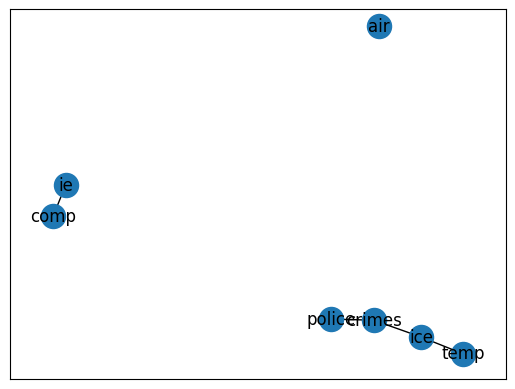

In [30]:
nx.draw_networkx(graph)

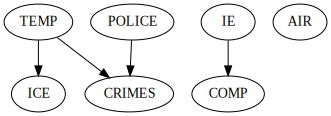

In [31]:
G = CausalGraphicalModel(nodes=['ICE','CRIMES','POLICE', 'TEMP','IE','COMP', 'AIR'],
edges=[('TEMP','ICE'),  ('TEMP','CRIMES'), ('IE','COMP'), ('POLICE', 'CRIMES')])
G.draw()

In [32]:
graph.edges

EdgeView([('police', 'crimes'), ('temp', 'ice'), ('ice', 'crimes'), ('ie', 'comp')])

## Задача про курение

In [33]:
smoke = []
cancer = []
tar = []

smoke += [1] * 323
cancer += [0]*323
tar+=[1]*323

smoke+=[0]
cancer+=[0]
tar+=[1]

smoke+=[1]*57
cancer+=[1]*57
tar+=[1]*57

smoke+=[0]*19
cancer+=[1]*19
tar+=[1]*19


smoke+=[1]*18
cancer+=[0]*18
tar+=[0]*18

smoke+=[0]*38
cancer+=[0]*38
tar+=[0]*38

smoke+=[1]*2
cancer+=[1]*2
tar+=[0]*2

smoke+=[0]*342
cancer+=[1]*342
tar+=[0]*342

dataframe = pd.DataFrame({'smoke':smoke, 'tar':tar, 'cancer':cancer})
dataframe.sample(5)

,smoke,tar,cancer
733,0,0,1
234,1,1,0
478,0,0,1
784,0,0,1
2,1,1,0


### Строим граф

In [34]:
g = nx.DiGraph()

In [35]:
g.add_nodes_from(['smoke','cancer','tar'])
g.add_edges_from([('tar','cancer'),('smoke','tar')])

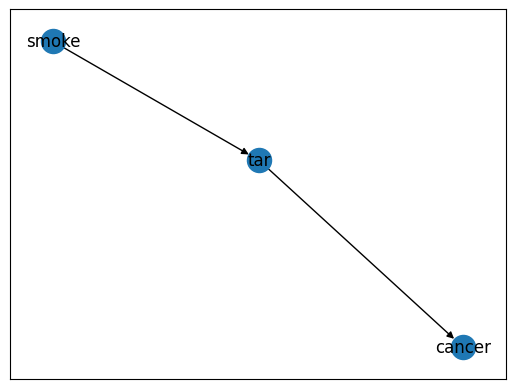

In [36]:
nx.draw_networkx(g)

### Иследуем причинность

In [37]:
adjustment = AdjustForDirectCauses()
admissable_set = adjustment.admissable_set(g,['tar'], ['cancer'])
admissable_set

{'smoke'}

In [38]:
dataframe.columns

Index(['smoke', 'tar', 'cancer'], dtype='object')

In [39]:
effect = CausalEffect(dataframe.sample(299), ['smoke'], ['cancer'],
                      variable_types={'smoke': 'u', 'cancer': 'u', 'tar': 'u'},
                      admissable_set=[])

In [40]:
smoke = pd.DataFrame({'smoke': [1], 'cancer': [1]})
nsmoke = pd.DataFrame({'smoke': [0], 'cancer': [1]})

In [41]:
effect.pdf(smoke) - effect.pdf(nsmoke)

-0.6226927944020787

## DoWhy

### Вилка

In [42]:
rs = np.random.RandomState(42)
X = []
Y = []
Z = []

Z+=[1]*100
Z+=[0]*100
X = [z if rs.uniform()<0.85 else rs.randint(low=0, high=2) for z in Z]
Y = [z if rs.uniform()<0.85 else rs.randint(low=0, high=2) for z in Z]

dataframe = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
dataframe.sample(5)

,X,Y,Z
80,1,1,1
22,1,1,1
51,1,1,1
2,1,1,1
31,1,1,1


Model to find the causal effect of treatment ['X'] on outcome ['Y']


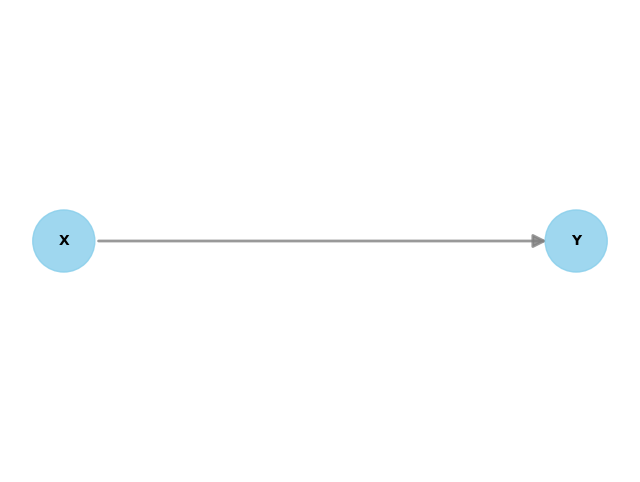

In [43]:
model_xy = CausalModel(
    data=dataframe,
    treatment=['X'],
    outcome=["Y"])
model_xy.interpret()

Model to find the causal effect of treatment ['X'] on outcome ['Y']


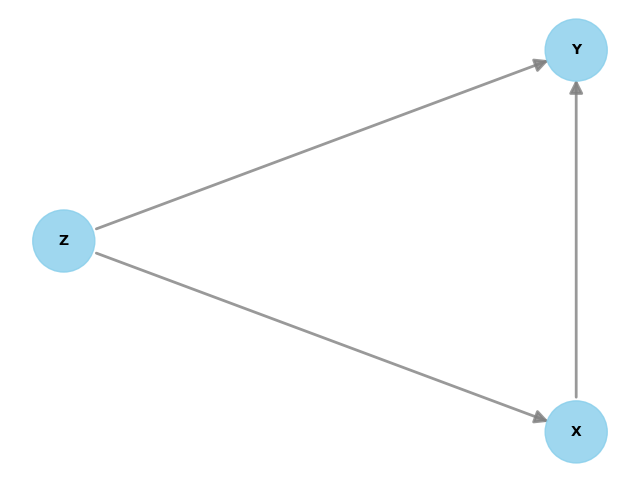

In [44]:
model_xyz = CausalModel(
    data=dataframe,
    treatment=['X'],
    outcome=["Y"], common_causes=['Z']  )
model_xyz.interpret()

#### Определяем эффект

In [45]:
print(model_xy.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [46]:
print(model_xyz.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Размер эффекта

In [47]:
print(
    model_xy.estimate_effect(
        model_xy.identify_effect(),
        method_name='backdoor.linear_regression',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

## Realized estimand
b: Y~X
Target units: ate

## Estimate
Mean value: 0.7599759975997601
p-value: [6.6231641e-39]



In [48]:
print(
    model_xyz.estimate_effect(
        model_xyz.identify_effect(),
        method_name='backdoor.linear_regression',
        test_significance=True, ))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

## Realized estimand
b: Y~X+Z
Target units: ate

## Estimate
Mean value: -0.06929740134744838
p-value: [0.36853613]



### Усложняем модель
- Z->X->Y
- U->X, U->Y,

где U --- это скрытая переменная, при оценке эффекта мы ее не видим, но предполагаем, что она существует

In [49]:
rs = np.random.RandomState(42)
X = []
Y = []
Z = []
U = []

U+=[1]*100
U+=[0]*100
Z += [1]*100
Z += [0] * 100
rs.shuffle(Z) # Z - еще одна переменная, которая влияет на X. Чтобы она не совпадала с U - помешаем.

X = [int((z+u)/2) if rs.uniform()<0.85 else rs.randint(low=0, high=2) for u,z in zip(U, Z)]
Y = [int((x+u)/2) for x,u in zip(X,U)]

dataframe = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
dataframe.sample(5)

,X,Y,Z
127,0,0,0
186,0,0,1
2,1,1,1
169,0,0,1
70,0,0,1


Model to find the causal effect of treatment ['X'] on outcome ['Y']


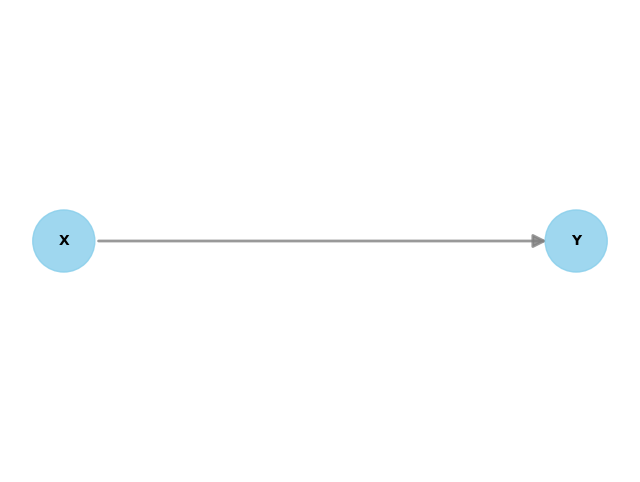

In [50]:
model_xy = CausalModel(
    data=dataframe,
    treatment=['X'],
    outcome=["Y"]   )
model_xy.interpret()

In [51]:
print(model_xy.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [52]:
print(
    model_xy.estimate_effect(
        model_xy.identify_effect(),
        method_name='backdoor.linear_regression',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

## Realized estimand
b: Y~X
Target units: ate

## Estimate
Mean value: 0.9272727272727277
p-value: [5.4915101e-102]



ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Model to find the causal effect of treatment ['X'] on outcome ['Y']


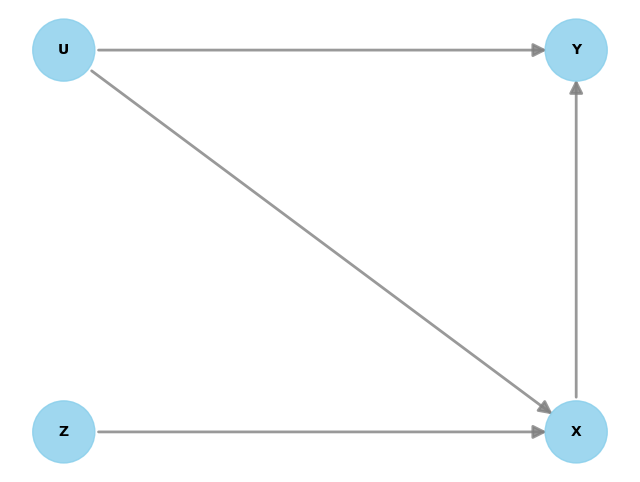

In [53]:
causal_graph = """digraph {
X[label="X"];
Y[label="Y"];
Z[label="Z"];
U[label="Unobserved Confounders",observed="no"];
U->{X;Y};
X->{Y};
Z->{X};
}"""

model = CausalModel(
    data=dataframe,
    treatment=['X'],
    instruments=['Z'],
    outcome=["Y"],
    graph=causal_graph)
model.interpret()

In [54]:
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [55]:
print(
    model.estimate_effect(
        model.identify_effect(),
        method_name='iv.instrumental_variable',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡d    ⎤  -1⎡d    ⎤
E⎢──(Y)⎥⋅E  ⎢──(X)⎥
 ⎣dZ   ⎦    ⎣dZ   ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['X'] is affected in the same way by common causes of ['X'] and ['Y']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['Y'] is affected in the same way by common causes of ['X'] and ['Y']

Target u

Теперь немного поменяем данные:
- Пусть Y в реальности зависит от скрытой переменной U но не зависит от X
- Корреляция X и Y при этом объясняется именно общим влиянием U

In [56]:
rs = np.random.RandomState(42)
X = []
Y = []
Z = []
U = []

U+=[1]*100
U+=[0]*100
Z += [1]*100
Z += [0] * 100
rs.shuffle(Z)

X = [int((z+u)/2) if rs.uniform()<0.85 else rs.randint(low=0, high=2) for u,z in zip(U, Z)]
Y = [u for x,u in zip(X,U)]

dataframe = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
dataframe.sample(5)

,X,Y,Z
123,0,0,0
144,1,0,1
12,0,1,0
45,1,1,0
59,1,1,1


Model to find the causal effect of treatment ['X'] on outcome ['Y']


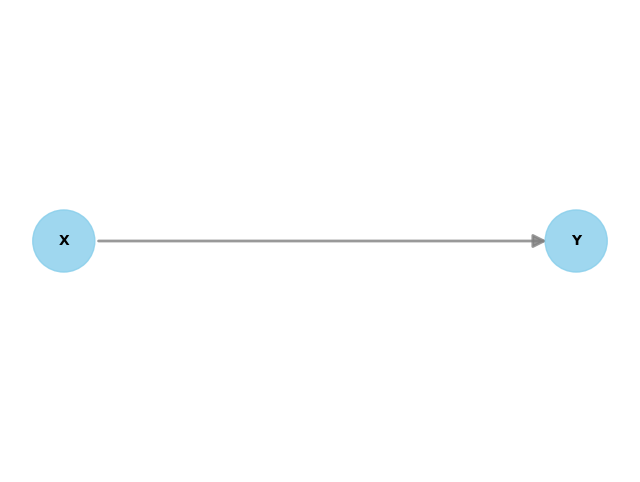

In [57]:
model = CausalModel(
    data=dataframe,
    treatment=['X'],
    outcome=["Y"])
model.interpret()

In [58]:
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [59]:
print(
    model.estimate_effect(
        model.identify_effect(),
        method_name='backdoor.linear_regression',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

## Realized estimand
b: Y~X
Target units: ate

## Estimate
Mean value: 0.5893416927899682
p-value: [1.20665026e-15]



ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Model to find the causal effect of treatment ['X'] on outcome ['Y']


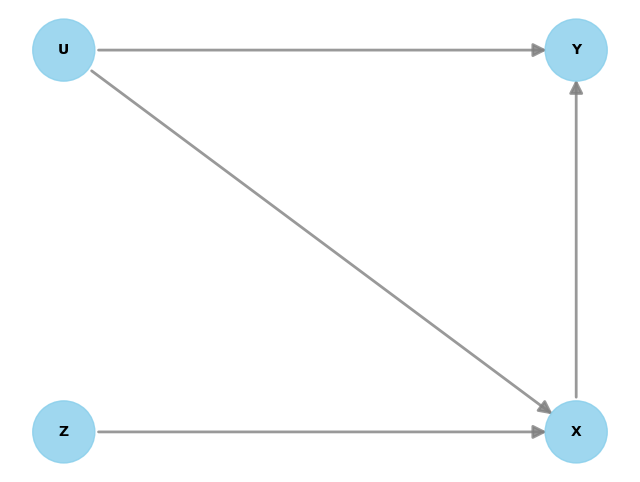

In [60]:
model = CausalModel(
    data=dataframe,
    treatment=['X'],
    instruments=['Z'],
    outcome=["Y"],
    graph=causal_graph)
model.interpret()

In [61]:
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [62]:
print(
    model.estimate_effect(
        model.identify_effect(),
        method_name='iv.instrumental_variable',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([X])⎟  ⎥
 ⎣d[Z]    ⎝d[Z]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: EstimandType.NONPARAMETRIC_ATE
Estimand expression:
 ⎡d    ⎤  -1⎡d    ⎤
E⎢──(Y)⎥⋅E  ⎢──(X)⎥
 ⎣dZ   ⎦    ⎣dZ   ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{X}, then ¬({Z}→Y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment ['X'] is affected in the same way by common causes of ['X'] and ['Y']
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome ['Y'] is affected in the same way by common causes of ['X'] and ['Y']

Target u

## Социо-Экономический Статус

In [63]:
causal_graph = """digraph {
X[label="X"];
Y[label="Y"];
Z[label="Z"];
U[label="Unobserved Confounders",observed="no"];
U->{X;Z};
X->{Y};
Z->{Y};
}"""

In [64]:
rs = np.random.RandomState(42)
U = [] # социо-экономический статус
X = [] # лечение больного
Y = [] # успешное лечение
Z = [] # наличие лишнего веса

U+=[1]*100
U+=[0]*100

Z = [u if rs.uniform()<0.85 else rs.randint(low=0, high=2) for u in U] #
X = [u if rs.uniform()<0.85 else rs.randint(low=0, high=2) for u in U]
Y = []
for x,z in zip(X,Z):
    # будем считать, что человек успешно вылечился, если назначено адекватное лечение и у него нет лишнего веса
    y = int((x + (1-z))/2)
    Y.append(y)


dataframe = pd.DataFrame({'X':X, 'Y':Y, 'Z':Z})
dataframe.sample(5)

,X,Y,Z
120,0,0,0
172,0,0,0
19,1,0,1
147,0,0,0
160,1,1,0


Model to find the causal effect of treatment ['X'] on outcome ['Y']


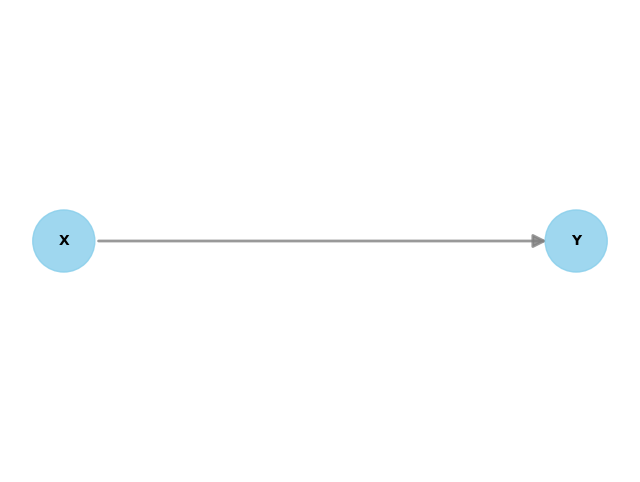

In [65]:
model = CausalModel(
    data=dataframe,
    treatment=['X'],
    outcome=["Y"])
model.interpret()

In [66]:
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [67]:
print(
    model.estimate_effect(
        model.identify_effect(),
        method_name='backdoor.linear_regression',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

## Realized estimand
b: Y~X
Target units: ate

## Estimate
Mean value: 0.11881188118811883
p-value: [0.00035403]



ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Model to find the causal effect of treatment ['X'] on outcome ['Y']


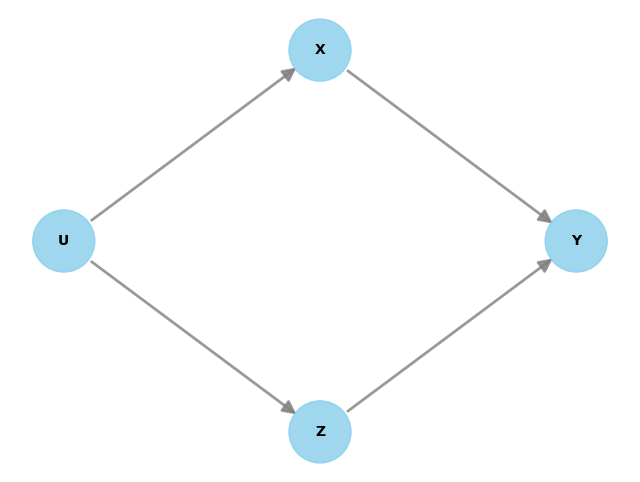

In [68]:
model = CausalModel(
    data=dataframe,
    treatment=['X'],
    outcome=["Y"],
    graph=causal_graph)
model.interpret()

In [69]:
print(model.identify_effect())

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [70]:
print(
    model.estimate_effect(
        model.identify_effect(),
        method_name='backdoor.linear_regression',
        test_significance=True))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

## Realized estimand
b: Y~X+Z+X*Z
Target units: 

## Estimate
Mean value: 0.4950000000000019
p-value: [0.]
### Conditional Estimates
__categorical__Z
(-0.001, 1.0]    0.495
dtype: float64


## И снова курение

In [71]:
smoke = []
cancer = []
tar = []

smoke += [1] * 323
cancer += [0]*323
tar+=[1]*323

smoke+=[0]
cancer+=[0]
tar+=[1]

smoke+=[1]*57
cancer+=[1]*57
tar+=[1]*57

smoke+=[0]*19
cancer+=[1]*19
tar+=[1]*19


smoke+=[1]*18
cancer+=[0]*18
tar+=[0]*18

smoke+=[0]*38
cancer+=[0]*38
tar+=[0]*38

smoke+=[1]*2
cancer+=[1]*2
tar+=[0]*2

smoke+=[0]*342
cancer+=[1]*342
tar+=[0]*342

dataframe = pd.DataFrame({'smoke':smoke, 'tar':tar, 'cancer':cancer})
dataframe.sample(5)

,smoke,tar,cancer
382,0,1,1
442,0,0,0
656,0,0,1
361,1,1,1
303,1,1,0


Model to find the causal effect of treatment ['smoke'] on outcome ['cancer']


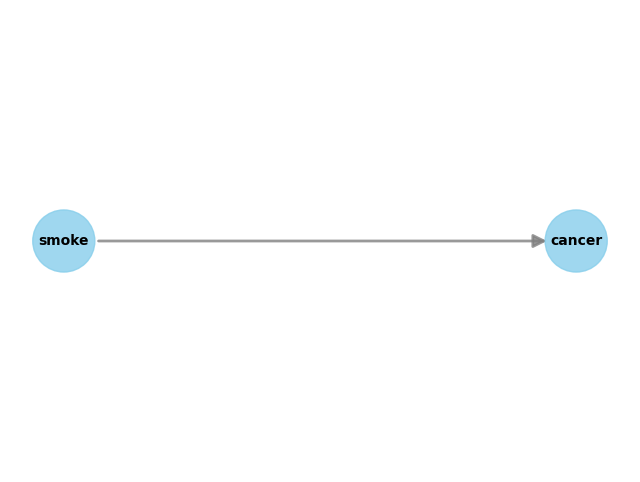

In [72]:
model = CausalModel(
    data=dataframe,
    treatment=['smoke'],
    outcome=["cancer"])
model.interpret()

In [73]:
print(model.identify_effect(proceed_when_unidentifiable=True))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[cancer])
d[smoke]           
Estimand assumption 1, Unconfoundedness: If U→{smoke} and U→cancer then P(cancer|smoke,,U) = P(cancer|smoke,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [74]:
print(
    model.estimate_effect(
        model.identify_effect(proceed_when_unidentifiable=True),
        method_name="backdoor.linear_regression", ))


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d               
────────(E[cancer])
d[smoke]           
Estimand assumption 1, Unconfoundedness: If U→{smoke} and U→cancer then P(cancer|smoke,,U) = P(cancer|smoke,)

## Realized estimand
b: cancer~smoke
Target units: ate

## Estimate
Mean value: -0.7550000000000004



Получением, что пристрастие к курению сильно снижает вероятность рака)))

In [75]:
causal_graph = """digraph {
smoke[label="smoke"];
tar[label="tar"];
cancer[label="cancer"];
U[label="Unobserved Confounders",observed="no"];
U->{smoke;cancer};
tar->{cancer};
smoke->{tar};
}"""

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Model to find the causal effect of treatment ['smoke'] on outcome ['cancer']


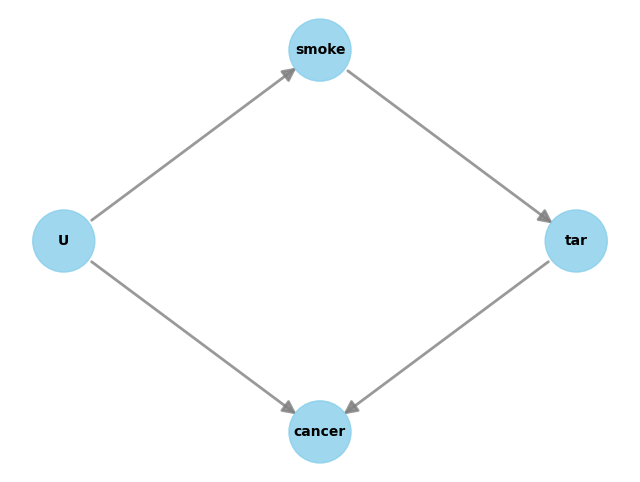

In [76]:
model = CausalModel(
    data=dataframe,
    treatment=['smoke'],
    outcome=["cancer"],
    instruments=["smoke"],
    graph=causal_graph)
model.interpret()

In [77]:
print(model.identify_effect(proceed_when_unidentifiable=True))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡  d               d           ⎤
E⎢──────(cancer)⋅────────([tar])⎥
 ⎣d[tar]         d[smoke]       ⎦
Estimand assumption 1, Full-mediation: tar intercepts (blocks) all directed paths from smoke to c,a,n,c,e,r.
Estimand assumption 2, First-stage-unconfoundedness: If U→{smoke} and U→{tar} then P(tar|smoke,U) = P(tar|smoke)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{tar} and U→cancer then P(cancer|tar, smoke, U) = P(cancer|tar, smoke)



In [78]:
print(
    model.estimate_effect(
        model.identify_effect(proceed_when_unidentifiable=True),
        method_name="frontdoor.two_stage_regression"))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡  d               d           ⎤
E⎢──────(cancer)⋅────────([tar])⎥
 ⎣d[tar]         d[smoke]       ⎦
Estimand assumption 1, Full-mediation: tar intercepts (blocks) all directed paths from smoke to c,a,n,c,e,r.
Estimand assumption 2, First-stage-unconfoundedness: If U→{smoke} and U→{tar} then P(tar|smoke,U) = P(tar|smoke)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{tar} and U→cancer then P(cancer|tar, smoke, U) = P(cancer|tar, smoke)

## Realized estimand
(b: tar~smoke)*(b: cancer~tar+smoke)
Target units: ate

## Estimate
Mean value: 0.044999999999999395

